In [1]:
#########################################################################
# Red convolucional preentrenada
# Usando Ajuste Fino (fine-tuning)
#########################################################################
# Descongelar las capas superiores de la base convolucional y congelar las restantes
# Entrenar conjuntamente la parte recién agregada del modelo y las capas superiores
# Ajusta ligeramente las representaciones más abstractas del modelo que se está 
# reutilizando, para que sean más relevantes para el problema en cuestión
# Realizado por Ximena Rios- Universidad del Valle
#########################################################################

In [16]:
#Parametros generales
IMG_ALTO = 150
IMG_ANCHO =150
LOTE_SIZE = 20 #tamaño de los lotes de datos

#Definir los directorios de trabajo 
import os
train_dir = os.getcwd() + '/base_datos/train/'
validacion_dir= os.getcwd() + '/base_datos/validacion/'
test_dir = os.getcwd() + '/base_datos/test/'

#Definir el nombre para guardar el modelos y los datos 
#nombre='Xception'
nombre='VGG16'
#nombre='VGG19'
#nombre='ResNet'
#nombre='ResNetV2'
#nombre='InceptionV3'
#nombre='InceptionResNetV2'
#nombre='MobileNet'
#nombre='MobileNetV2'
#nombre='DenseNet121'
#nombre='NASNet'

In [3]:
#crear una instancia de la base convolucional  
#from keras.applications import Xception
from keras.applications import VGG16
#from keras.applications import VGG19
#from keras.applications import ResNet
#from keras.applications import ResNetV2
#from keras.applications import InceptionV3
#from keras.applications import InceptionResNetV2
#from keras.applications import MobileNet
#from keras.applications import MobileNetV2
#from keras.applications import DenseNet121
#from keras.applications import NASNet

#conv_base = Xception(
conv_base = VGG16(
#conv_base = VGG16(weights='imagenet',  #punto de control de peso inicializar el modelo
#conv_base = VGG19(
#conv_base = ResNet(
#conv_base = ResNetV2(
#conv_base = InceptionV3(
#conv_base = InceptionResNetV2(
#conv_base = MobileNet(
#conv_base = MobileNetV2(
#conv_base = DenseNet121(
#conv_base = NASNet(
    include_top=False, #incluir o no la red densamente conectada
    input_shape=(150, 150, 3)) #forma del tensor de entrada
#https://keras.io/applications/

Using TensorFlow backend.


In [4]:
#Adicionar una capa densamente conectada al final de la base convolucional
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(15, activation='softmax')) 
#capa densa de tamaño 15. para cada entrada la red saca un vector de 15 dimensiones. cada entrada en este vector codifica una clase diferente de salida 
# activacion softmax significa que la red puede sacar una distribucion de probabilidad sobre 15 diferentes clases de salida

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                3855      
Total params: 16,815,951
Trainable params: 16,815,951
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Congelar la base convolucional
#print('Este es numero de pesos entrenables antes de congelar la conv_base:', len(model.trainable_weights))
conv_base.trainable = False
#print('Este es numero de pesos entrenables despues de congelar la conv_base:', len(model.trainable_weights))

In [7]:
#Crear una instancia de la clase ImageDataGenerator para el aumento de datos
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255, # Todas las imágenes serán reescaladas por 1./255
    width_shift_range=0.2, #son rangos(una fraccion del total) dentro de los cuales se puede trasladar una figura aleatoreamente
    height_shift_range=0.2,
    #shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,#Voltear aleatoriamente las entradas horizontalmente
    vertical_flip=True, 
    fill_mode='nearest') #nearest #reflect constant
#Note que los datos de validacion no deben ser aumentados!!!
test_datagen = ImageDataGenerator(rescale=1./255)
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=stable

In [8]:
#Generar datos por el metodo flow_from_directory de la clase ImageDataGenerator
#Datos de entrenamiento
train_generator = train_datagen.flow_from_directory(
    train_dir, #directorio de trabajo
    target_size=(150, 150), # Tamaño de las imágenes (serán redimensionadas)
    batch_size=20, #Tamaño de los lotes de datos (cantidad de imagenes generadas)
    class_mode='categorical')# Como usamos la funcion depérdida categorical_crossentropy, necesitamos etiquetas categorical
    #categorical--> will be 2D one-hot encoded labels
    #produce lotes de imágenes RGB de 150x150 (forma (20, 150, 150, 3)) y etiquetas 2D one-hot  (forma (20,))
#Datos de validacion
validation_generator = test_datagen.flow_from_directory(
    validacion_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')

Found 4664 images belonging to 15 classes.
Found 591 images belonging to 15 classes.


In [9]:
#compilar
from keras import optimizers
model.compile(optimizer='rmsprop',
    loss='categorical_crossentropy', #funcion de activacion para clasificacion multiclase
    metrics=['acc'])  #categorical_crossentropy, espera que las etiquetas sigan una codificación categórica
    #categorical--> will be 2D one-hot encoded labels

#model.compile(loss='categorical_crossentropy',
#    optimizer=optimizers.RMSprop(lr=2e-5),
#    metrics=['acc'])

In [10]:
#Entrenar la red
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 27s 270ms/step - loss: 2.5772 - acc: 0.2160 - val_loss: 2.0838 - val_acc: 0.3340
Epoch 2/30
100/100 [==============================] - 27s 268ms/step - loss: 2.2570 - acc: 0.2820 - val_loss: 1.9102 - val_acc: 0.3717
Epoch 3/30
100/100 [==============================] - 27s 272ms/step - loss: 2.1038 - acc: 0.3330 - val_loss: 1.8928 - val_acc: 0.4012
Epoch 4/30
100/100 [==============================] - 26s 256ms/step - loss: 2.0437 - acc: 0.3465 - val_loss: 1.7335 - val_acc: 0.4016
Epoch 5/30
100/100 [==============================] - 24s 241ms/step - loss: 1.9512 - acc: 0.3780 - val_loss: 1.6207 - val_acc: 0.4969
Epoch 6/30
100/100 [==============================] - 29s 290ms/step - loss: 1.9289 - acc: 0.3930 - val_loss: 1.6802 - val_acc: 0.4633
Epoch 7/30
100/100 [==============================] - 25s 246ms/step - loss: 1.9695 - acc: 0.3870 - val_loss: 1.5247 - val_acc: 0.5106
Epoch 8/30
100/100 [==============================] - 2

In [11]:
#Descongelar la red
conv_base.trainable = True

In [12]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [13]:
#Congelar todas las capas hasta una específica
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
#compilar
model.compile(loss='categorical_crossentropy', #funcion de activacion para clasificacion multiclase
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

In [15]:
#Entrenar la red
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 28s 279ms/step - loss: 1.6544 - acc: 0.4875 - val_loss: 1.2400 - val_acc: 0.6226
Epoch 2/100
100/100 [==============================] - 27s 273ms/step - loss: 1.6002 - acc: 0.5060 - val_loss: 1.2105 - val_acc: 0.6191
Epoch 3/100
100/100 [==============================] - 26s 259ms/step - loss: 1.5605 - acc: 0.5215 - val_loss: 1.2574 - val_acc: 0.6100
Epoch 4/100
100/100 [==============================] - 25s 252ms/step - loss: 1.6063 - acc: 0.5055 - val_loss: 1.2439 - val_acc: 0.6398
Epoch 5/100
100/100 [==============================] - 27s 266ms/step - loss: 1.5325 - acc: 0.5115 - val_loss: 1.2178 - val_acc: 0.6242
Epoch 6/100
100/100 [==============================] - 25s 247ms/step - loss: 1.5031 - acc: 0.5315 - val_loss: 1.2329 - val_acc: 0.6314
Epoch 7/100
100/100 [==============================] - 27s 266ms/step - loss: 1.4685 - acc: 0.5410 - val_loss: 1.1808 - val_acc: 0.6609
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 26s 258ms/step - loss: 1.1591 - acc: 0.6310 - val_loss: 1.0412 - val_acc: 0.7053
Epoch 62/100
100/100 [==============================] - 28s 282ms/step - loss: 1.1873 - acc: 0.6260 - val_loss: 1.1376 - val_acc: 0.6660
Epoch 63/100
100/100 [==============================] - 25s 254ms/step - loss: 1.1464 - acc: 0.6300 - val_loss: 1.1432 - val_acc: 0.6864
Epoch 64/100
100/100 [==============================] - 25s 251ms/step - loss: 1.1596 - acc: 0.6335 - val_loss: 1.0954 - val_acc: 0.7033
Epoch 65/100
100/100 [==============================] - 25s 248ms/step - loss: 1.1751 - acc: 0.6380 - val_loss: 1.0961 - val_acc: 0.6853
Epoch 66/100
100/100 [==============================] - 27s 265ms/step - loss: 1.2206 - acc: 0.6205 - val_loss: 1.0398 - val_acc: 0.6904
Epoch 67/100
100/100 [==============================] - 26s 258ms/step - loss: 1.1522 - acc: 0.6235 - val_loss: 1.0727 - val_acc: 0.7064
Epoch 68/100
100/100 [===================

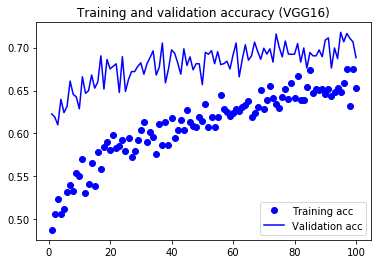

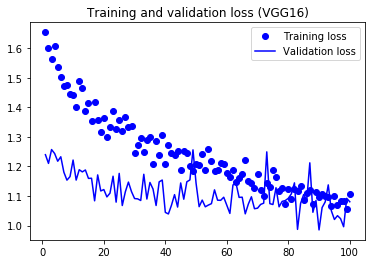

In [18]:
#graficar
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc') #Entrenamiento acc
plt.plot(epochs, val_acc, 'b', label='Validation acc') #Validación acc
#plt.xlabel('Epochs'); plt.ylabel('acc')
plt.title('Training and validation accuracy ('+nombre+')') # Entrenamiento y validación (precisión acc)
plt.legend()
plt.savefig(nombre+'Fine.png') #guardar figura #plt.savefig('VGG16Fine.png')

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss ('+nombre+')') #Entrenamiento y validación (función de perdida)
plt.legend()
plt.savefig(nombre+'FineL.png') #guardar figura #plt.savefig('VGG16L.png')
plt.show()

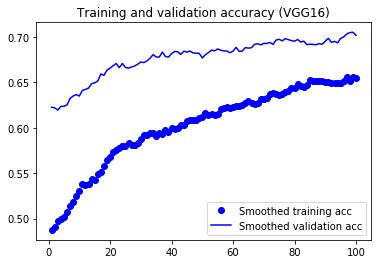

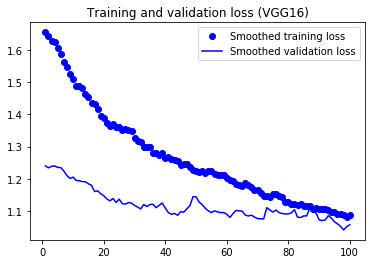

In [19]:
#Suavizando las graficas (reemplazando con promedios de movimiento exponencial)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy ('+nombre+')') # Entrenamiento y validación (precisión acc)
plt.legend()
plt.savefig(nombre+'FineS.png') #guardar figura #plt.savefig('VGG16FineS.png')

plt.figure()
plt.plot(epochs,smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss ('+nombre+')') #Entrenamiento y validación (función de perdida)
plt.legend()
plt.savefig(nombre+'FineLS.png') #guardar figura #plt.savefig('VGG16FineLS.png')
plt.show()

In [20]:
#########################################################################
# Evaluar el modelo cargado con los datos de test
#########################################################################
#Generar datos por el metodo flow_from_directory de la clase ImageDataGenerator
#Datos de test
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='categorical')
#Evaluar el modelo con los datos de test
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc,'  test loss:', test_loss )

Found 585 images belonging to 15 classes.
test acc: 0.6649746177765319   test loss: 1.226297148744467


In [21]:
#guardar un modelo 
model.save(nombre+'Fine.h5') #model.save('VGG16.h5')

In [22]:
#guardar el history para graficar despues
import json
with open(nombre+'FineHistory.json', 'w') as f:
#with open('VGG16History.json', 'w') as f:
    json.dump(history.history, f)

In [23]:
#guardar la precision de test
import json
with open(nombre+'FineTest.json', 'w') as f:
#with open('VGG16Test.json', 'w') as f:
    json.dump((test_loss, test_acc), f)